In [1]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to c:\users\enhan\appdata\local\temp\pip-req-build-9ojoqrzr
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 6a9c8dadac04eb85befc935043e3e2cce914267f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git 'C:\Users\enhan\AppData\Local\Temp\pip-req-build-9ojoqrzr'

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from chronos import ChronosPipeline
import time
import re

In [23]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map = "cpu",
    torch_dtype=torch.bfloat16,
)

In [40]:
# Load the data

filename = "2023-06-01_2023-08-31_load_per_hour.csv"
input_filename = f"data/{filename}"
data = pd.read_csv(input_filename)

# Split the data into 80% training and 20% testing
train_size = int(len(data) * 0.8)
train_data = data["load"][:train_size]
test_data = data["load"][train_size:]

# Convert training and testing data to tensors
train_context = torch.tensor(train_data.values, dtype=torch.float32)
test_context = torch.tensor(test_data.values, dtype=torch.float32)

In [41]:
# Predict on the testing data
prediction_length = len(test_context)
start_time = time.time()
forecast = pipeline.predict(train_context, prediction_length)
end_time = time.time()
training_time = end_time- start_time
print(training_time)

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


160.14297747612


In [42]:
# Convert predictions to DataFrames
#fitted_df = pd.DataFrame(fitted_values[0][19], columns=["Fitted Load"])
#forecast_df = pd.DataFrame(forecast[0][19], columns=["Predicted Load"])
median_forecast = np.median(forecast[0], axis=0)

# Convert the median forecast to a DataFrame
median_forecast_df = pd.DataFrame({
    "Index": np.arange(len(median_forecast)),  # Indices corresponding to prediction steps
    "Median Predicted Load": median_forecast
})
date_range = re.search(r"\d{4}-\d{2}-\d{2}_\d{4}-\d{2}-\d{2}", input_filename).group()
median_forecast_df.to_csv(
        f"forecasting_results/chronos_results/testing_predictions_with_actual_{date_range}.csv",
        index=False)

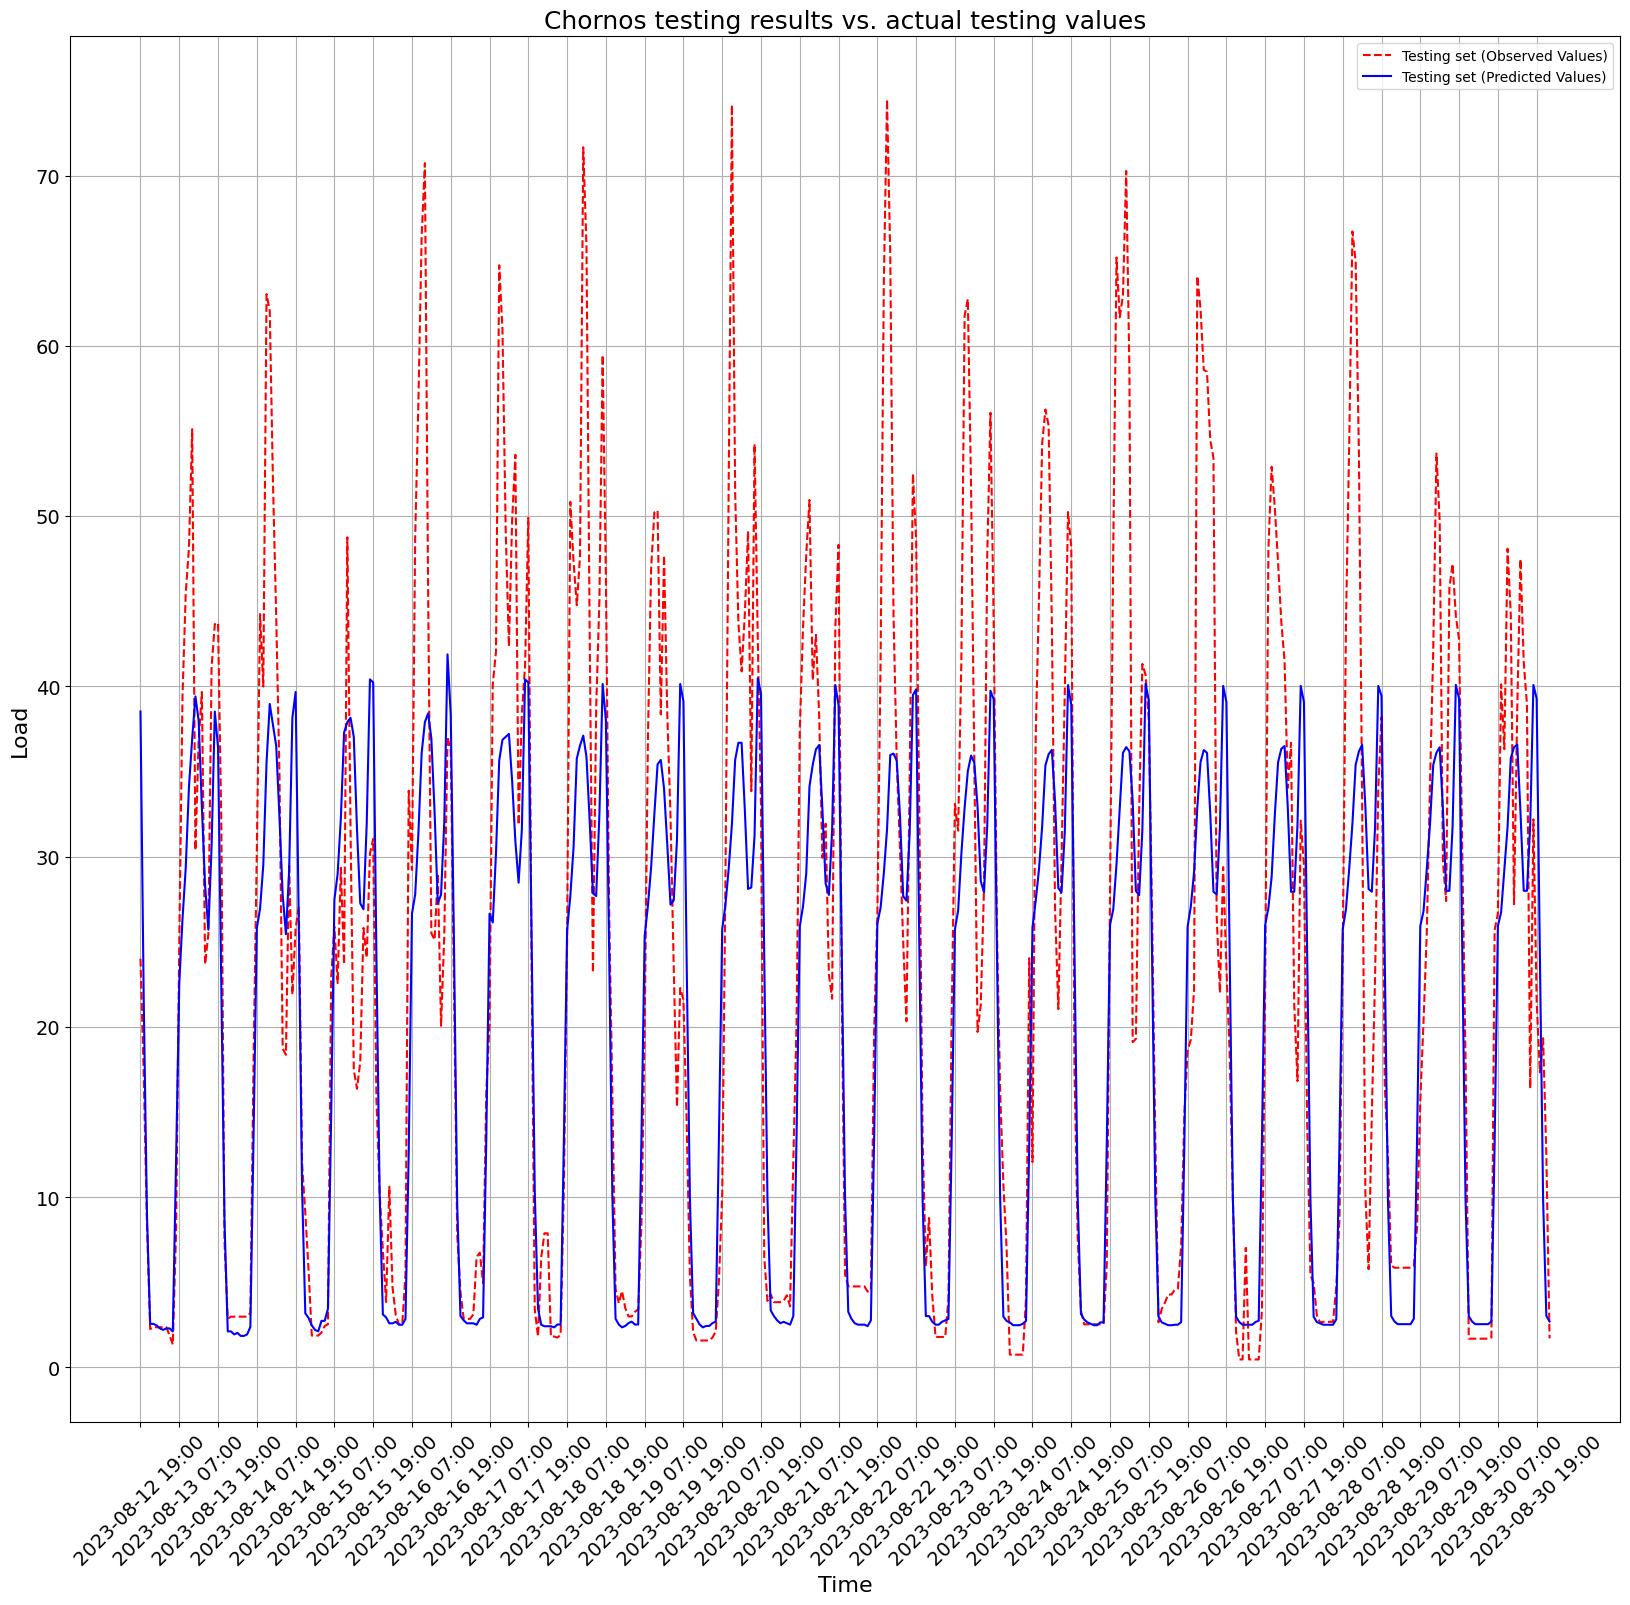

In [43]:
# Ensure "date" is in datetime format
data["date"] = pd.to_datetime(data["date"])
# Plot the results
plt.figure(figsize=(20, 18))

# Plot testing data
plt.plot(data["date"][train_size:], test_data, label="Testing set (Observed Values)", color="red", linestyle="--")
plt.plot(data["date"][train_size:], median_forecast_df["Median Predicted Load"], label="Testing set (Predicted Values)", color="blue")

# Select every 6th timestamp for x-ticks
six_hour_ticks = data["date"][train_size::12]

# Set x-ticks to every 6 hours
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("X Axis Label", fontsize=16)
plt.ylabel("Y Axis Label", fontsize=16)
plt.title("Chornos testing results vs. actual testing values", fontsize=18)

plt.xticks(ticks=six_hour_ticks, labels=six_hour_ticks.dt.strftime("%Y-%m-%d %H:%M"), rotation=45)

plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.savefig(f"forecasting_results/chronos_results/time_series_comparison_actual_vs_predicted_testing_set_{date_range}.png")
plt.show()


Mean Squared Error (MSE): 127.86009201347592
Mean absolute percentage Error (MAPE): 0.44631044738543374
Mean absolute error (MAE): 7.729426267126643
R² Score: 0.6725380682788262


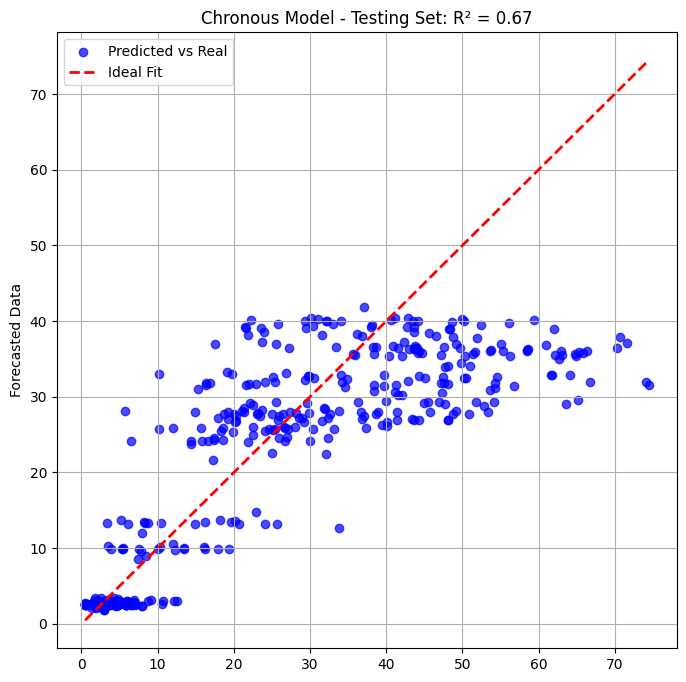

In [44]:
# Compute MSE and R² Score
test_mse = mean_squared_error(test_data, median_forecast)
test_MAPE = mean_absolute_percentage_error(test_data, median_forecast)
test_mae = mean_absolute_error(test_data, median_forecast)
test_r2 = r2_score(test_data, median_forecast)

# Print the metrics
print(f"Mean Squared Error (MSE): {test_mse}")
print(f"Mean absolute percentage Error (MAPE): {test_MAPE}")
print(f"Mean absolute error (MAE): {test_mae}")
print(f"R² Score: {test_r2}")

# Scatter plot of real vs. forecasted testing data
plt.figure(figsize=(8, 8))
plt.scatter(test_data, median_forecast, alpha=0.7, color="blue", label="Predicted vs Real")
plt.plot([test_data.min(), test_data.max()], [test_data.min(), test_data.max()], color="red", lw=2, linestyle="--", label="Ideal Fit")
plt.title(f'Chronous Model - Testing Set: R² = {test_r2:.2f}')
plt.ylabel("Forecasted Data")
plt.legend()
plt.grid(True)
plt.savefig("comparison_actual_vs_predicted_testing_set.pdf")
plt.show()

In [45]:
fitted_values = []
for i in range(len(train_context)):
    # Predict the next point based on context up to the current point
    prediction = pipeline.predict(train_context[:i+1], prediction_length=1)
    fitted_values.append(prediction[0][19][0])  # Adjust indexing as necessary

# Convert fitted values to a NumPy array or DataFrame for comparison
fitted_values = np.array(fitted_values)

KeyboardInterrupt: 

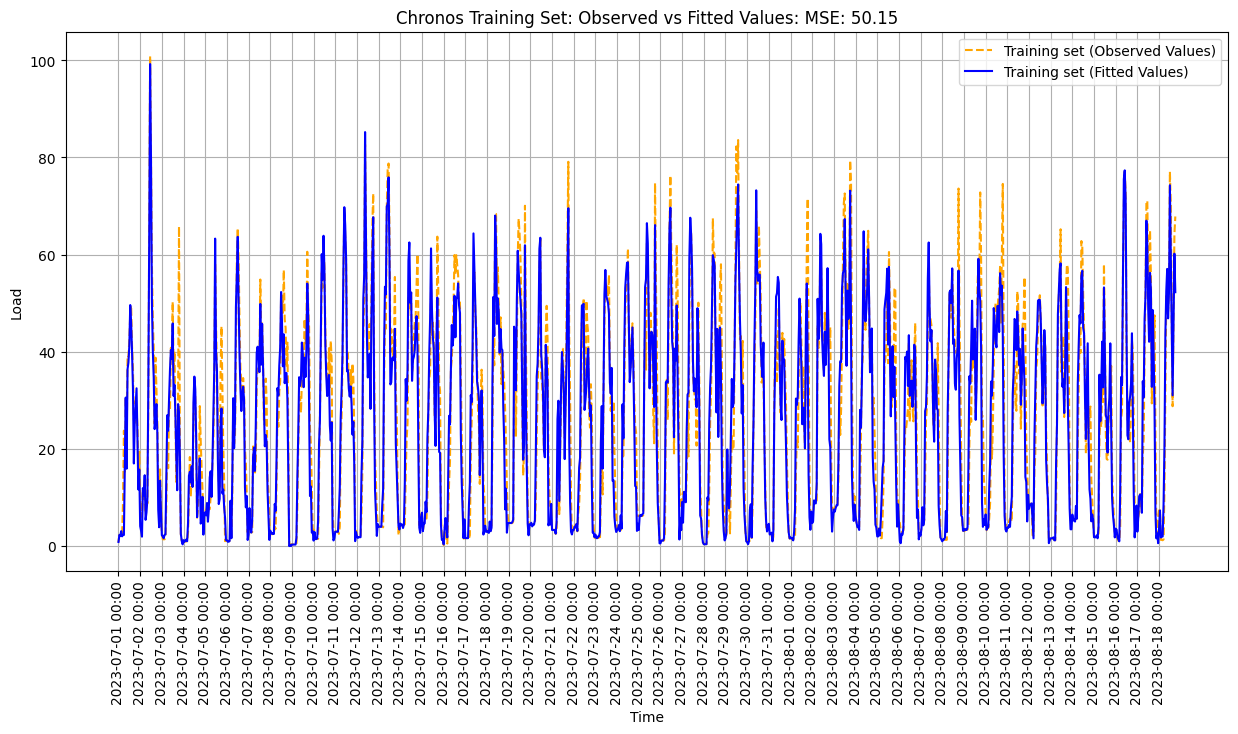

In [59]:
# Ensure "date" is in datetime format
data["date"] = pd.to_datetime(data["date"])

train_mse = mean_squared_error(train_data, fitted_values)
# Plot the results
plt.figure(figsize=(15, 7))

# Plot testing data
plt.plot(data["date"][:train_size], train_data, label="Training set (Observed Values)", color="orange", linestyle="--")
plt.plot(data["date"][:train_size], fitted_values, label="Training set (Fitted Values)", color="blue")

# Select every steps of timestamp for x-ticks
step_hour_ticks = data["date"][:train_size:24]

# Set x-ticks to every 6 hours
plt.xticks(ticks=step_hour_ticks, labels=step_hour_ticks.dt.strftime("%Y-%m-%d %H:%M"), rotation=90)

plt.title(f"Chronos Training Set: Observed vs Fitted Values: MSE: {train_mse:.2f}")
plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.savefig("Time_series_comparison_actual_vs_predicted_training_set_2023-07-01_2023-08-31_load_per_hour.pdf")
plt.show()

Mean Squared Error (MSE): 141.58416456250131
R² Score: 0.7445639461969327


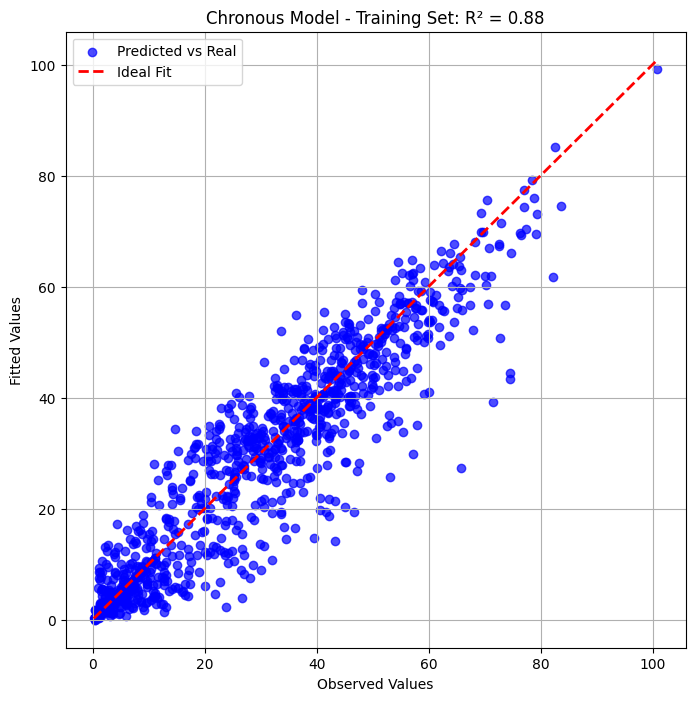

In [62]:
# Compute MSE and R² Score
train_r2 = r2_score(train_data, fitted_values)

# Print the metrics
print(f"Mean Squared Error (MSE): {test_mse}")
print(f"R² Score: {test_r2}")

# Scatter plot of real vs. forecasted testing data
plt.figure(figsize=(8, 8))
plt.scatter(train_data, fitted_values, alpha=0.7, color="blue", label="Predicted vs Real")
plt.plot([train_data.min(), train_data.max()], [train_data.min(), train_data.max()], color="red", lw=2, linestyle="--", label="Ideal Fit")
plt.title(f'Chronous Model - Training Set: R² = {train_r2:.2f}')
plt.xlabel("Observed Values")
plt.ylabel("Fitted Values")
plt.legend()
plt.grid(True)
plt.savefig("comparion_actual_vs_predicted_training_set_2023-07-01_2023-08-31_load_per_hour.pdf")
plt.show()